In [1]:
cd /content/drive/MyDrive/Colab Notebooks/cours_python/FSCI2610/projet/Finale

/content/drive/MyDrive/Colab Notebooks/cours_python/FSCI2610/projet/Finale


In [2]:
!pip install numpy scipy matplotlib librosa ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00


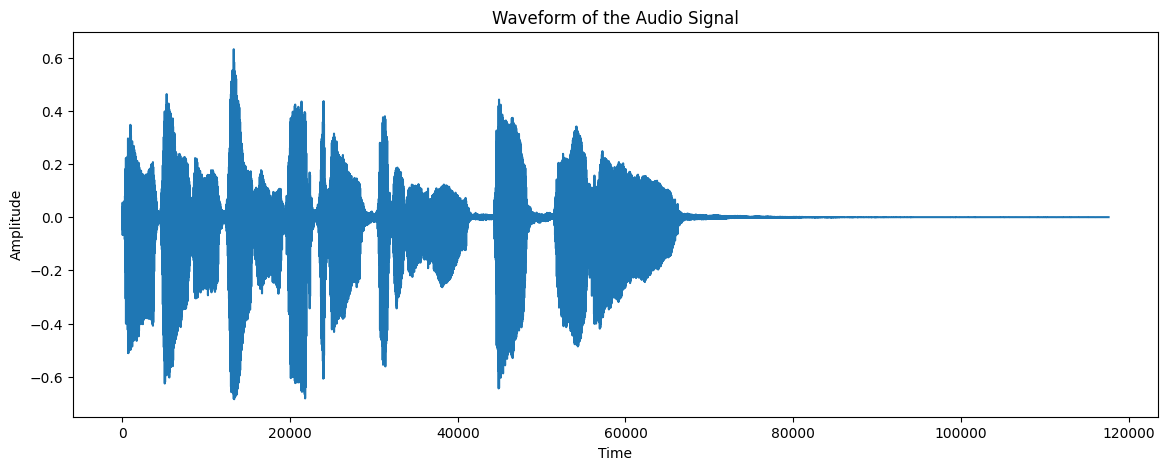

In [3]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Load the audio file
audio_path = librosa.example('trumpet')
y, sr = librosa.load(audio_path)

# Plot the waveform
plt.figure(figsize=(14, 5))
plt.plot(y)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


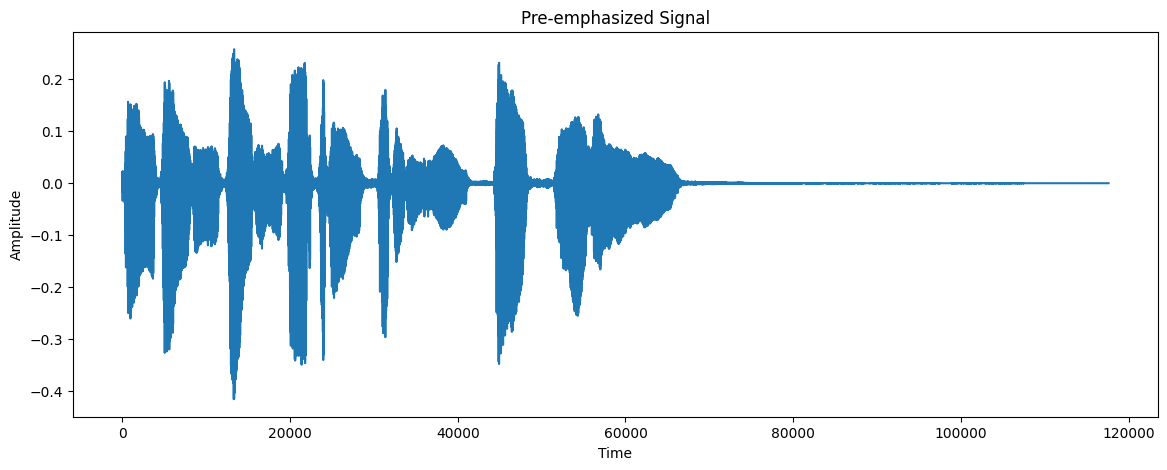

In [4]:
# Apply pre-emphasis filter
pre_emphasis = 0.97
y_preemphasized = np.append(y[0], y[1:] - pre_emphasis * y[:-1])

# Plot the pre-emphasized signal
plt.figure(figsize=(14, 5))
plt.plot(y_preemphasized)
plt.title('Pre-emphasized Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


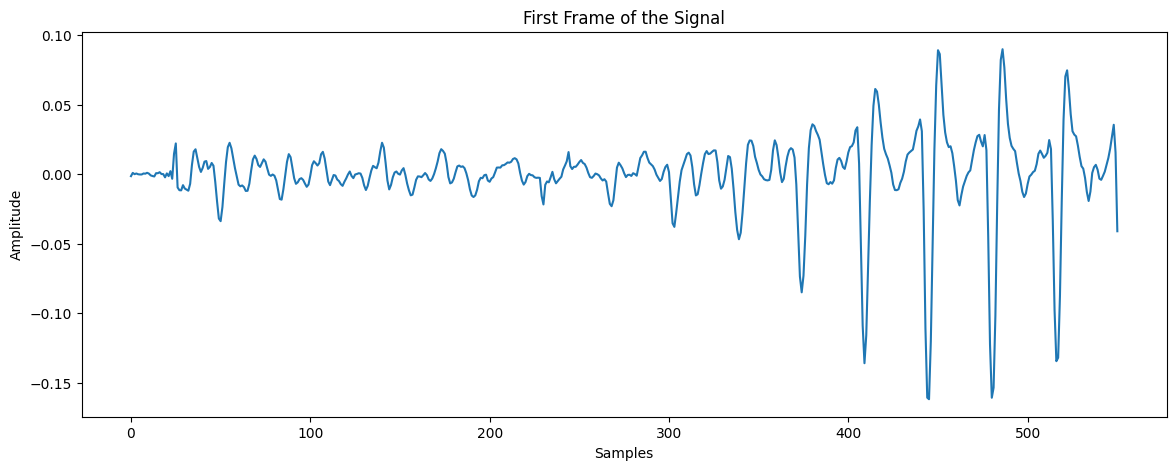

In [6]:
frame_size = 0.025  # 25 ms
frame_stride = 0.01  # 10 ms
frame_length, frame_step = frame_size * sr, frame_stride * sr  # Convert from seconds to samples
signal_length = len(y_preemphasized)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

# Pad signal to ensure all frames have equal number of samples
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(y_preemphasized, z)

# Slice the signal into frames
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

# Plot a few frames
plt.figure(figsize=(14, 5))
plt.plot(frames[0])
plt.title('First Frame of the Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()



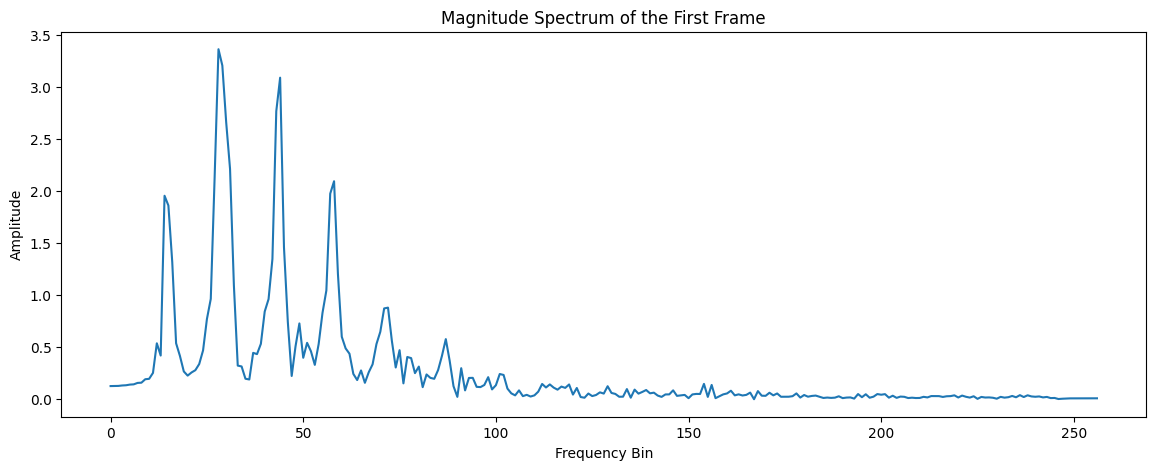

In [7]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

# Plot the magnitude spectrum of the first frame
plt.figure(figsize=(14, 5))
plt.plot(mag_frames[0])
plt.title('Magnitude Spectrum of the First Frame')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')
plt.show()


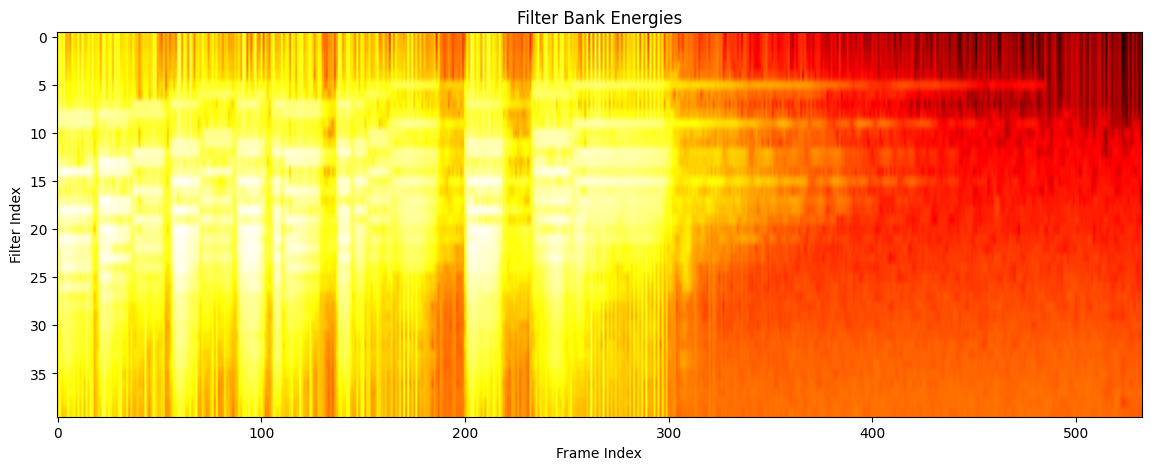

In [8]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sr / 2) / 700)  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = 700 * (10 ** (mel_points / 2595) - 1)  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sr)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical stability
filter_banks = 20 * np.log10(filter_banks)  # dB

# Plot the filter bank energies
plt.figure(figsize=(14, 5))
plt.imshow(filter_banks.T, cmap='hot', aspect='auto')
plt.title('Filter Bank Energies')
plt.xlabel('Frame Index')
plt.ylabel('Filter Index')
plt.show()


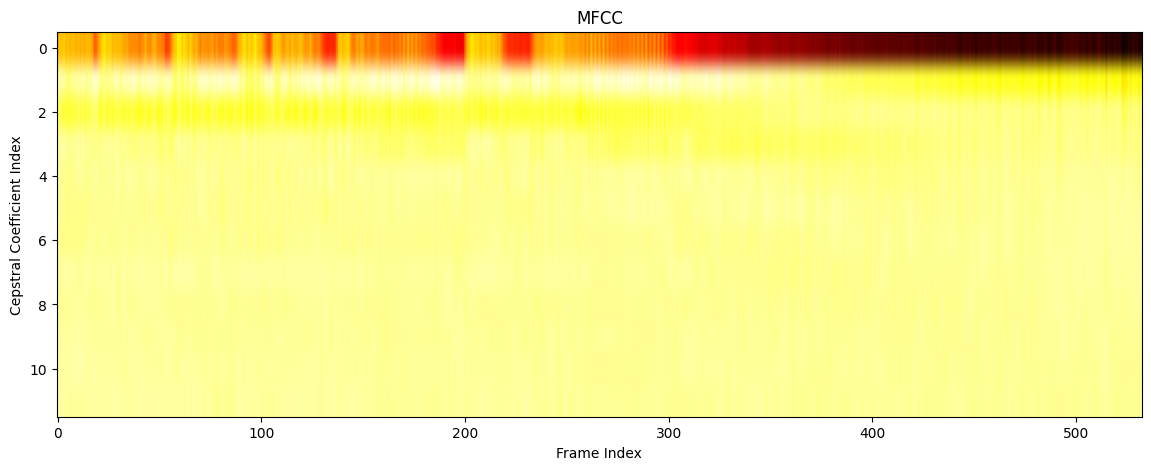

In [9]:
from scipy.fftpack import dct

num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, :num_ceps]

# Plot the MFCCs
plt.figure(figsize=(14, 5))
plt.imshow(mfcc.T, cmap='hot', aspect='auto')
plt.title('MFCC')
plt.xlabel('Frame Index')
plt.ylabel('Cepstral Coefficient Index')
plt.show()


In [12]:
import librosa.display
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Audio
from scipy.fftpack import dct
import io
import numpy as np
import matplotlib.pyplot as plt

# File uploader widget
uploader=widgets.FileUpload(accept='.wav',multiple=False)

# Load and compute MFCCs for a given audio file
def compute_mfcc(file):
    pre_emphasis=0.97
    frame_size=0.025
    frame_stride=0.01
    NFFT=512
    nfilt=40
    num_ceps=12

    y, sr=librosa.load(io.BytesIO(file), sr=None)
    frame_length=int(round(frame_size*sr))  # Convert from seconds to samples
    frame_step=int(round(frame_stride*sr))  # Convert from seconds to samples

    y_preemphasized=np.append(y[0],y[1:]-pre_emphasis*y[:-1])
    signal_length=len(y_preemphasized)
    num_frames=int(np.ceil(float(np.abs(signal_length-frame_length))/frame_step))
    pad_signal_length=num_frames*frame_step+frame_length
    z=np.zeros((pad_signal_length-signal_length))
    pad_signal=np.append(y_preemphasized,z)
    indices=np.tile(np.arange(0,frame_length),(num_frames,1))+np.tile(np.arange(0,num_frames*frame_step,frame_step),(frame_length,1)).T
    frames=pad_signal[indices.astype(np.int32,copy=False)]
    frames*=np.hamming(frame_length)
    mag_frames=np.absolute(np.fft.rfft(frames,NFFT))
    pow_frames=((1.0/NFFT)*((mag_frames)**2))

    # Calculate fbank within the function to make it accessible
    low_freq_mel=0
    high_freq_mel=2595*np.log10(1+(sr/2)/700)  # Convert Hz to Mel
    mel_points=np.linspace(low_freq_mel,high_freq_mel,nfilt+2)  # Equally spaced in Mel scale
    hz_points=700*(10**(mel_points/2595)-1)  # Convert Mel to Hz
    bin=np.floor((NFFT+1)*hz_points/sr)

    fbank=np.zeros((nfilt,int(np.floor(NFFT/2+1))))
    for m in range(1,nfilt+1):
        f_m_minus=int(bin[m-1])   # left
        f_m=int(bin[m])           # center
        f_m_plus=int(bin[m+1])    # right

    for k in range(f_m_minus,f_m):
        fbank[m-1,k]=(k-bin[m-1])/(bin[m]-bin[m-1])
    for k in range(f_m,f_m_plus):
        fbank[m-1,k]=(bin[m+1]-k)/(bin[m+1]-bin[m])

    filter_banks=np.dot(pow_frames,fbank.T)
    filter_banks=np.where(filter_banks==0,np.finfo(float).eps,filter_banks)
    filter_banks=20*np.log10(filter_banks)
    mfcc=dct(filter_banks,type=2,axis=1,norm='ortho')[:,:num_ceps]

    plt.figure(figsize=(14,5))
    plt.subplot(2,1,1)
    librosa.display.waveshow(y,sr=sr)
    plt.title('Waveform')
    plt.subplot(2,1,2)
    plt.imshow(mfcc.T,cmap='hot',aspect='auto')
    plt.title('MFCC')
    plt.xlabel('Frame Index')
    plt.ylabel('Cepstral Coefficient Index')
    plt.tight_layout()
    plt.show()

FileUpload(value={}, accept='.wav', description='Upload')

Button(description='Use Sample Audio', style=ButtonStyle())

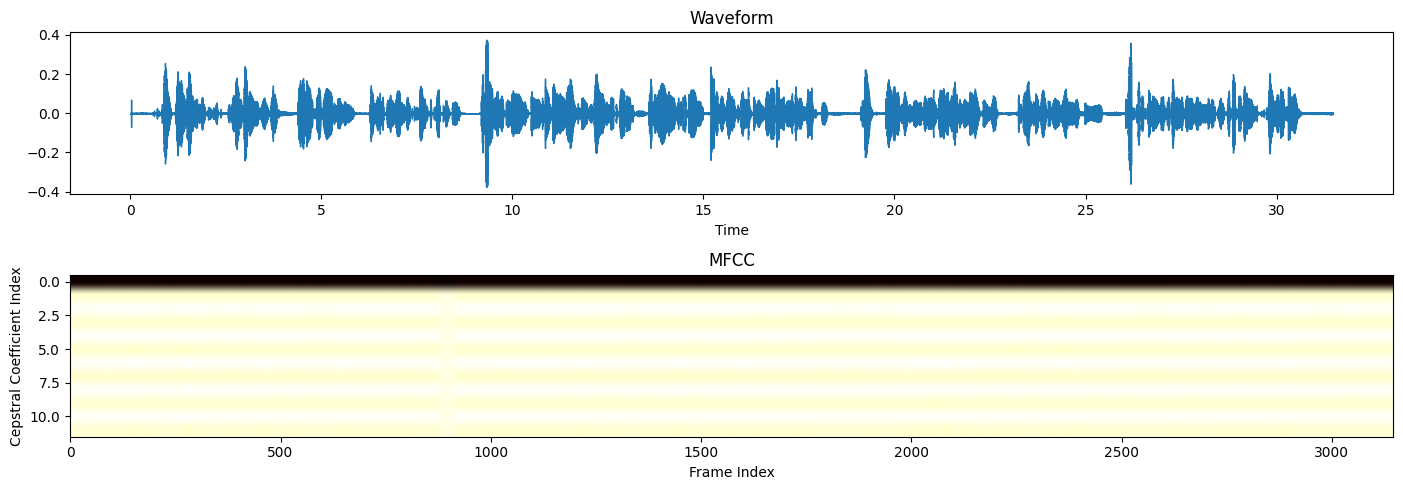

In [13]:
# Handle file upload and compute MFCCs
def on_upload_change(change):
    file = list(uploader.value.values())[0]
    compute_mfcc(file['content'])

uploader.observe(on_upload_change, names='value')

# Button to compute MFCCs for the sample audio file
sample_button = widgets.Button(description='Use Sample Audio')
def on_sample_button_click(b):
    sample_audio_path = './voice_samples/Normal_Voice.wav'  # Define sample_audio_path here
    # Read the file content in binary mode
    with open(sample_audio_path, 'rb') as f:
        file_content = f.read()
    compute_mfcc(file_content)  # Pass the file content to compute_mfcc

sample_button.on_click(on_sample_button_click)

# Display widgets
display(uploader, sample_button)